## Preliminaries


In [1]:
## Import libraries
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd 
import numpy as np
import seaborn as sns
import sklearn as sk 
import scipy 
 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, RocCurveDisplay
from scipy.stats import norm

In [2]:
df = pd.read_csv('DataSet.csv')

basic_stats = df.describe()
print(basic_stats)


          MinTemp     MaxTemp    Rainfall  Evaporation    Sunshine  \
count  907.000000  907.000000  907.000000   907.000000  907.000000   
mean    13.414333   23.428335    4.402867     5.105072    7.054686   
std      6.417740    7.261593   11.423447     3.410964    3.962936   
min     -2.500000    7.200000    0.000000     0.000000    0.000000   
25%      8.600000   17.200000    0.000000     2.600000    3.800000   
50%     12.900000   23.500000    0.000000     4.400000    7.800000   
75%     18.500000   29.500000    4.200000     7.000000   10.300000   
max     29.700000   42.900000  168.400000    22.800000   13.800000   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm    Humidity  Pressure9am  \
count     907.000000    907.000000    907.000000  907.000000   907.000000   
mean       43.628445     17.275634     20.678060   53.879824  1016.186880   
std        14.703012      8.924449      8.995093   21.092195     7.214124   
min        15.000000      2.000000      2.000000    1.000000 

In [3]:
#dropping variables
df = df.drop(['RainToday','RainTomorrow'], axis=1)

#extracting date, findinf month, then dummying month in order to make it a quantitive variable
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
dummies = pd.get_dummies(df['Month'], prefix='Month')
df = pd.concat([df, dummies], axis=1)
df = df.drop('Date', axis=1)

#getting dummies for WindDir
catColumns = ['WindDir']
df = pd.get_dummies(df, columns=catColumns, drop_first=True)

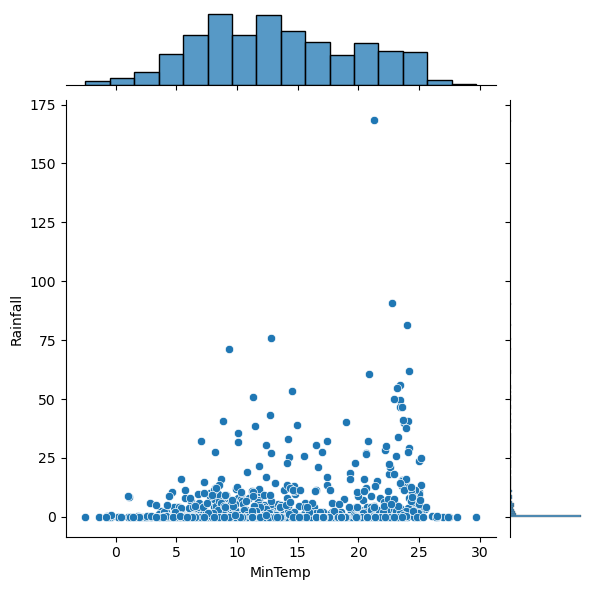

In [4]:
sns.jointplot(y='Rainfall', x='MinTemp', data=df, kind='scatter')
plt.show()
#plotting with sns docu

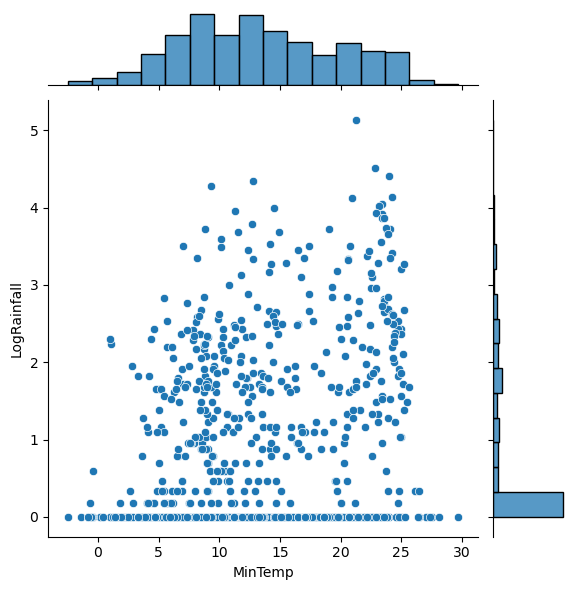

In [5]:
df['LogRainfall'] = np.log1p(df['Rainfall'])
sns.jointplot(y='LogRainfall', x='MinTemp', data=df, kind='scatter')
plt.show()
# doing the same thing as above but making 'Rainfall' variable logarithmic

In [6]:
df2 = pd.read_csv('DataSet.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2['Month'] = df2['Date'].dt.month
df2 = df2.drop('Date', axis=1)

In [7]:
def FourierExpansion(x,order):
    scale = x/np.max(x)
    designMatrix = np.column_stack((np.sin(2*np.pi*scale), np.cos(2*np.pi*scale)))

    for i in range(2,order+1):
        sinColumn = np.sin(2*i*np.pi*scale)
        cosColumn = np.cos(2*i*np.pi*scale)
        designMatrix = np.column_stack((designMatrix, sinColumn, cosColumn))

    return designMatrix

In [8]:
order = 6
X1 = FourierExpansion(df2['Month'], order)

X2 = pd.get_dummies(df2['Month'], prefix='Month', drop_first=True)

y = df2['Evaporation']

model1 = LinearRegression().fit(X1, y)
model2 = LinearRegression().fit(X2, y)

yPred = model1.predict(X1)
yPredict = model2.predict(X2)

r2Fourier = r2_score(y, yPred)
r2Dummies = r2_score(y, yPredict)

print("Fourier Expansion r2:", r2Fourier)
print("Get Dummies r2:", r2Dummies)


Fourier Expansion r2: 0.36628272544252105
Get Dummies r2: 0.36628272544252105


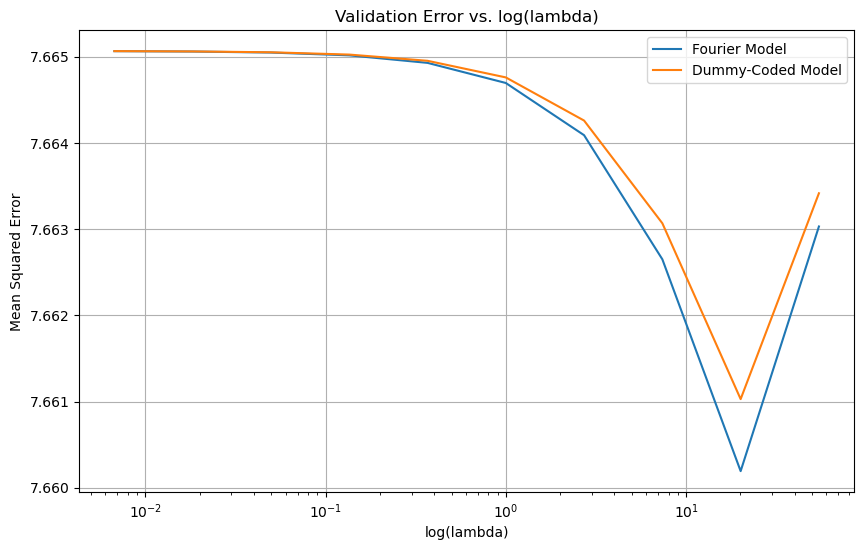

Best Lambda for Fourier Model: 0.006737946999085467
Best Lambda for Dummy-Coded Model: 0.006737946999085467


In [9]:


# Define the order for Fourier expansion or polynomial feature set
order = 11  


X_dummy = pd.get_dummies(df2['Month'], prefix='Month')


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])


param_grid = {
    'model__alpha': np.exp(np.linspace(-5, 4, 10))
}
grid_search_fourier = GridSearchCV(pipeline, param_grid, cv=10, scoring=make_scorer(mean_squared_error), n_jobs=-1)
grid_search_fourier.fit(X1, y)


grid_search_dummy = GridSearchCV(pipeline, param_grid, cv=10, scoring=make_scorer(mean_squared_error), n_jobs=-1)
grid_search_dummy.fit(X_dummy, y)


best_lamF = grid_search_fourier.best_params_['model__alpha']
best_lamD = grid_search_dummy.best_params_['model__alpha']

# Plot the average validation error against log(lambda) for both models
plt.figure(figsize=(10, 6))
plt.semilogx(np.exp(np.linspace(-5, 4, 10)), grid_search_fourier.cv_results_['mean_test_score'], label='Fourier Model')
plt.semilogx(np.exp(np.linspace(-5, 4, 10)), grid_search_dummy.cv_results_['mean_test_score'], label='Dummy-Coded Model')
plt.xlabel('log(lambda)')
plt.ylabel('Mean Squared Error')
plt.title('Validation Error vs. log(lambda)')
plt.legend()
plt.grid()
plt.show()

# Report the best lambda values for each model
print("Best Lambda for Fourier Model:", best_lamF)
print("Best Lambda for Dummy-Coded Model:", best_lamD)
